In [41]:
from sklearn.ensemble import IsolationForest
import pandas as pd
import numpy as np
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt

In [42]:
df = pd.read_csv("dataset.csv", index_col = 0, delimiter = ',')

In [43]:
model = IsolationForest(contamination=0.05)
model.fit(df)
df['anomaly'] = model.predict(df)
print("Number of anomalies detected: ", sum(df['anomaly'] == -1))


/Users/macbook/Library/jupyterlab-desktop/jlab_server/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


Number of anomalies detected:  512


In [44]:
df['anomaly']

time
0.00        -1
60.48        1
120.96       1
181.44       1
241.92       1
            ..
604679.00    1
604740.00    1
604800.00    1
604800.00   -1
604800.00   -1
Name: anomaly, Length: 10330, dtype: int64

In [45]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

normal_data = df[df['anomaly'] == 1] 
anomaly_data = df[df['anomaly'] == -1]

# Normalize the data
sc = StandardScaler()
normal_data = sc.fit_transform(normal_data)


X_train, X_val = train_test_split(normal_data, test_size=0.2, random_state=42)

input_dim = X_train.shape[1]  
encoding_dim = 10 
input_layer = tf.keras.layers.Input(shape=(input_dim, ))
encoder = tf.keras.layers.Dense(encoding_dim, activation="tanh")(input_layer)
encoder = tf.keras.layers.Dense(int(encoding_dim / 2), activation="relu")(encoder)
decoder = tf.keras.layers.Dense(encoding_dim, activation='tanh')(encoder)
decoder = tf.keras.layers.Dense(input_dim, activation='relu')(decoder)

autoencoder = tf.keras.models.Model(inputs=input_layer, outputs=decoder)


autoencoder.compile(optimizer='adam', loss='mean_squared_error')


autoencoder.fit(X_train, X_train,
                epochs=50,
                batch_size=32,
                shuffle=True,
                validation_data=(X_val, X_val),
                verbose=1)

X_test = sc.transform(df)
predicted = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - predicted, 2), axis=1)
df['mse'] = mse

threshold = np.percentile(df['mse'], 95)

df['anomaly'] = df['mse'] > threshold


Epoch 1/50
246/246 [==============================] - 4s 5ms/step - loss: 0.7325 - val_loss: 0.6661
Epoch 2/50
246/246 [==============================] - 1s 4ms/step - loss: 0.6198 - val_loss: 0.6208
Epoch 3/50
246/246 [==============================] - 1s 4ms/step - loss: 0.5720 - val_loss: 0.5749
Epoch 4/50
246/246 [==============================] - 1s 4ms/step - loss: 0.5433 - val_loss: 0.5624
Epoch 5/50
246/246 [==============================] - 1s 4ms/step - loss: 0.5340 - val_loss: 0.5523
Epoch 6/50
246/246 [==============================] - 1s 4ms/step - loss: 0.5254 - val_loss: 0.5410
Epoch 7/50
246/246 [==============================] - 1s 4ms/step - loss: 0.5179 - val_loss: 0.5314
Epoch 8/50
246/246 [==============================] - 1s 4ms/step - loss: 0.5118 - val_loss: 0.5227
Epoch 9/50
246/246 [==============================] - 1s 5ms/step - loss: 0.5071 - val_loss: 0.5153
Epoch 10/50
246/246 [==============================] - 1s 4ms/step - loss: 0.5035 - val_loss: 0.5101

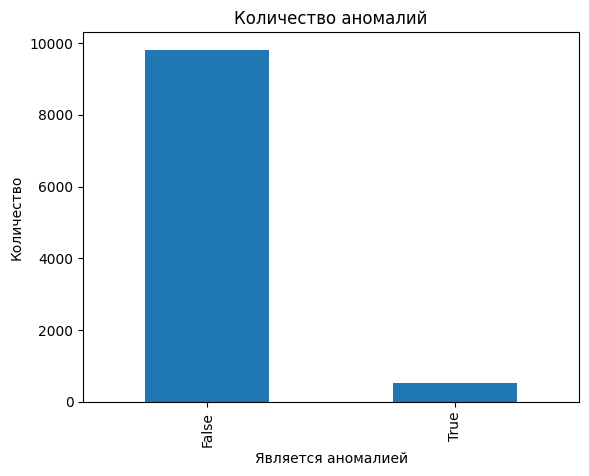

In [46]:
# Считаем количество нормальных и аномальных значений
df['anomaly'].value_counts().plot(kind='bar')

# Задаем название графика
plt.title('Количество аномалий')

# Подписываем ось X
plt.xlabel('Является аномалией')

# Подписываем ось Y
plt.ylabel('Количество')

# Показываем график
plt.show()


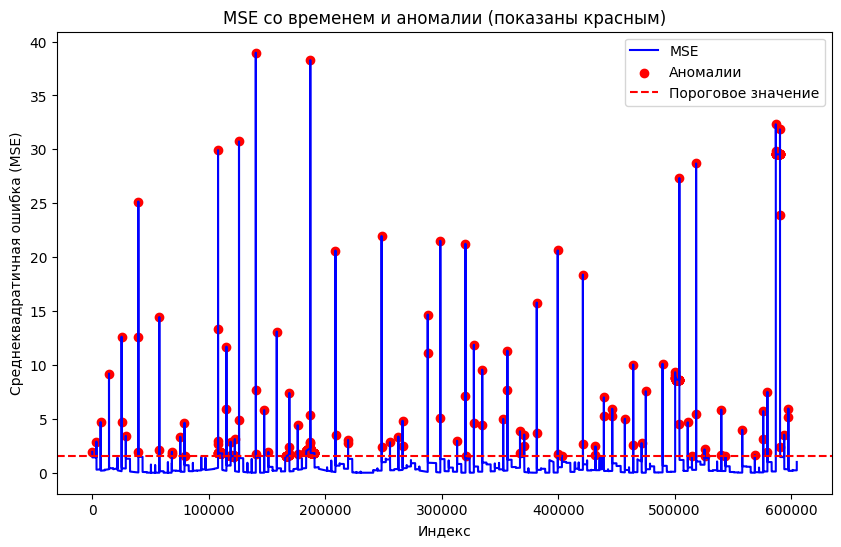

In [47]:
# Сохраняем только строки с аномалиями
anomaly_df = df[df['anomaly'] == True]

# Создаем новую фигуру для графика
plt.figure(figsize=(10, 6))

# Рисуем график MSE по времени
plt.plot(df.index, df['mse'], 'b', label='MSE')

# Выделяем аномалии на графике
plt.scatter(anomaly_df.index, anomaly_df['mse'], color='red', label='Аномалии')

# Рисуем горизонтальную линию, показывающую пороговое значение
plt.axhline(y=threshold, color='r', linestyle='--', label='Пороговое значение')

# Задаем название графика
plt.title('MSE со временем и аномалии (показаны красным)')

# Обозначаем оси графика
plt.xlabel('Индекс')
plt.ylabel('Среднеквадратичная ошибка (MSE)')

# Добавляем легенду
plt.legend()

# Показываем график
plt.show()
